# Градиентный спуск

### Генерируем значения

In [1]:
from math import pi
from math import sin
from math import cos

k = 51
omega = 100 / k
L = k / 10
dt = 2 * pi / 1000

ys = [0 for _ in range(500)]
ys[1], ys[2] = 0, (-1)**k*dt

for i in range(500 - 2):
    ys[i+2] = ys[i+1]*(2+dt*L*(1-ys[i]**2))-ys[i]*(1+dt**2+dt*L*(1-ys[i]**2))+dt**2*sin(omega*i*dt)

xs = list(range(500))

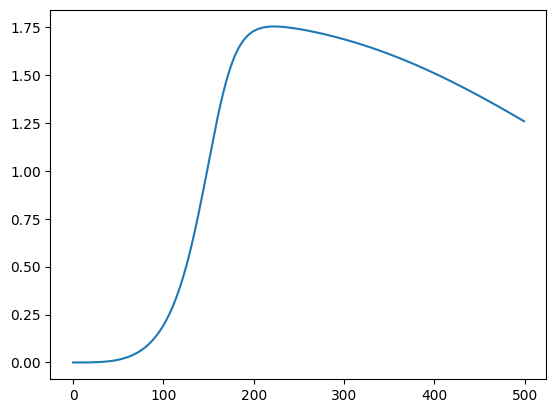

In [2]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)
plt.show()

## Гармоническое разложение (аппроксимация)
> Разложение в ряд из 2-х гармоник
> 
> X[i] = a0 + a1 cos($\omega{_1}$ i dt) + b1 sin($\omega{_1}$ i dt) + a2 cos($\omega{_2}$ i dt) + b2 sin($\omega{_2}$ i dt)
>
> Подбираем частоты ($\omega$*) и коэффициенты (a\*, b\*)

> Градиентный спуск ищет минимум функции. Чтобы найти коэффициенты, мы должны минимизировать функцию ошибки (отклонение точек аппроксимации от реальных точек).
> Градиент $\nabla{F}$ показывает направление наибольшего роста, $-\nabla{F}$ -- наискорейшего спуска
>
> На каждой итерации мы меняем приближение в сторону $-\nabla{F}$:
> 
> $\theta = \theta - \alpha \cdot \nabla{F(\theta)}$

In [3]:
# Градиент
# f - функция
# theta - точка 
def gradient(f, theta : list, h = 1e-8) -> list:
    grad = []
    # Считаем частные производные для каждой координаты
    for i, _ in enumerate(theta):
        left_theta = theta.copy()
        left_theta[i] -= h
        
        right_theta = theta.copy()
        right_theta[i] += h
        grad.append( ( f(right_theta) - f(left_theta) ) / (2 * h) )
    return grad

### Пакетный градиентный спуск

In [4]:
from math import sqrt

def gradient_descent(f, theta : list, eps = 1e-6) -> (list, list):
    theta_ = theta.copy()
    history = [f(theta)]
    step = 0.01
    
    for _ in range(1000):
        # Градиент
        grad = gradient(f, theta_)

        # Значение функции для заданного шага
        #f_arbitrary_step = lambda alpha: f([ theta_[x] - alpha * grad[x] for x, _ in enumerate(theta_) ])
        # Линейная минимизация для поиска шага
        #step = gold_section_minimization(f_arbitrary_step, 0, 1)
        
        # Новое приближение
        new_theta_ = [ theta_[x] - step * grad[x] for x, _ in enumerate(theta_) ]
        # Критерий остановки
        # hypot считает гипотенузу (корень из суммы квадратов)
        if sqrt( sum( ( (new_theta_[x] - theta_[x])**2 for x, _ in enumerate(theta) ) ) ) < eps: break

        theta_ = new_theta_
        history.append(f(theta_))

        # Меняем шаг
        if history[-1] > history[-2]: step *= 0.5
    return theta_, history

# Линейная минимизация -- метод золотого сечения
def gold_section_minimization(f, start : float, end : float):
    phi = (1 + sqrt(5)) / 2
    while(abs(end - start) > 1e-6):
        x1 = end - (end - start) / phi
        x2 = start + (end - start) / phi
        
        if f(x1) < f(x2): end = x2
        else: start = x1
    return (start + end) / 2

### Стохастический градиентный спуск

In [5]:
from random import randint

#def minimize_stochastic(f, x, y, a_0, h_0 = 0.1, max_steps = 1000):
def minimize_stochastic(f, xs : list, ys : list, theta : list, step = 0.1, max_steps = 1000, eps = 1e-6) -> (list, list):
    theta_ = theta
    h = step
    min_theta_, min_F = None, float('inf') # Лучшее приближение и значение функции
    drunken_steps = 0 # Счётчик бесполезных (пьяных) шагов 
    while drunken_steps < max_steps:
        # Стало ли значение функции ближе к минимуму?
        new_F = sum( (f(x, theta_) - y)**2 for x, y in zip(xs,ys) )
        if new_F < min_F:
            # Стало
            min_theta_, min_F = theta_, new_F
            drunken_steps = 0 # Обнуляем счётчик пьяных шагов
            h = step # Обнуляем размер шага
        else:
            # Не стало -- пьяный шаг
            drunken_steps += 1 # Увеличиваем счётчик
            h *= 0.9 # Уменьшаем шаг -- чтобы упасть глубже если случайно перепрыгиваем
            rand_x = randint(0,len(xs)-1) # Выбираем случайную точку
            # Считаем градиент для одной точки
            grad = []
            for i,_ in enumerate(theta_):
                theta_h = theta_.copy()
                theta_h[i] += h
                # главное - в этом шаге (суммы нет!)
                grad.append(( (f(xs[rand_x], theta_h) - ys[rand_x])**2 - (f(xs[rand_x],theta_) - ys[rand_x])**2 ) / h)
            # Новое приближение
            theta_ = [theta_[i] - h*grad[i] for i,_ in enumerate(theta_)]
    
    return min_theta_, min_F

### Функция потерь и гармонической аппроксимации

In [6]:
# Аппроксимация
def harmonic_approx(x : int, theta : list ) -> float:
    a0, a1, b1, a2, b2, om1, om2 = theta
    return (a0 + a1 * cos(om1 * x * dt) 
            + b1 * sin(om1 * x * dt) 
            + a2 * cos(om2 * x * dt) 
            + b2 * sin(om2 * x * dt))

# Функция потерь -- для минимизации
# Среднеквадратическая ошибка между исходными точками и аппроксимацией
def F(theta : list) -> float:
    a0, a1, b1, a2, b2, om1, om2 = theta
    total_err = 0.0
    for i in xs:
        predict = harmonic_approx(i, theta)
        err = ys[i] - predict
        total_err += err ** 2
    return total_err / len(ys)

# Для конкретной точки
def F_for_x(x : int, theta : list) -> float:
    predict = harmonic_approx(x, theta)
    err = ys[x] - predict
    return err**2

## Получаем точки

In [7]:
import time

# Начальное приближение
init_theta = [0.0, 1.0, 1.0, 0.5, 0.5, 1.0, 2.0]

# Пакетный градиентный спуск
start_time = time.time()
packet_theta, _ = gradient_descent(F, init_theta)
end_time = time.time()
packet_time = end_time - start_time

In [8]:
# Стохастический градиентный спуск
start_time = time.time()
stochastic_theta, _ = minimize_stochastic(harmonic_approx, xs, ys, init_theta)
end_time = time.time()
stochastic_time = end_time - start_time

## График

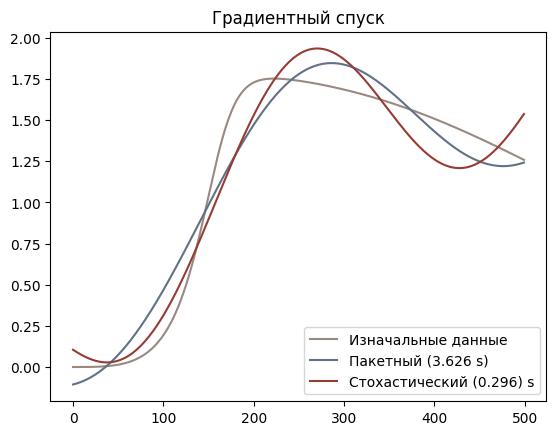

In [9]:
packet_ys = [harmonic_approx(x, packet_theta) for x in xs]
stochastic_ys = [harmonic_approx(x, stochastic_theta) for x in xs]

plt.plot(xs, ys, color='#998982', label="Изначальные данные")
plt.plot(xs, packet_ys, color='#617187', label=f"Пакетный ({packet_time:.3f} s)")
plt.plot(xs, stochastic_ys, color='#953D34', label=f"Стохастический ({stochastic_time:.3f}) s")
plt.title("Градиентный спуск")
plt.legend()
plt.show()


# Вывод
> Стохастический градиентный спуск намного быстрее засчёт того, что не ищет значения для всех точек, но он менее точен и непостоянен

> Когда точность критична лучше использовать пакетный градиентный спуск. Когда важнее скорость -- стохастический

In [10]:
F(packet_theta)

0.02290409904894779

In [11]:
F(stochastic_theta)

0.02553892192523439